# Preprocessing & visualization 

## Introduction

This chapter will guide you through the steps of data preprocessing and visualization. Pre-processing aims to address the following analysis steps: doublet detection, quality control, normalization, feature selection, and dimensionality reduction. {cite}`germain_pipecomp_2020` provide with their pipeline comparison *PipeComp* a benchmark of the interactions between different preprocessing steps. In the following we refer to the tools recommended in this independent benchmark and complement is with python based tools that are frequently used by the scRNA-seq community. This chapter will additionally introduce the advanced topics of ambient RNA, single nuclei and interactive visualization. 

The starting point of this notebook are raw sequencing data generated by sequencing machines. The data was processed and aligned to obtain matrices of molecular counts, so called count matrices, or read counts (read matrices). The difference between count and read matrices depends on whether unique molecular identifiers (UMIs) were included in the single-cell library construction protocol. Read and count matrices have the dimension number of barcodes x number of transcripts. It is important to note that the term "barcode" is used here instead of "cell" as a barcode might wrongly have tagged multiple cells (doublet) or might have not tagged any cell (empty droplet/well). We will elaborate more on this in the next section "Doublet detection". 

### Dataset
We first load the dataset with scanpy which can be downloaded from figshare (ADD LINK). We use a human bone marrow dataset from .... CITE. 

In [2]:
import scanpy as sc
sc.settings.verbosity = 0

In [3]:
adata = sc.read('cellranger_neurips21_bmmc.h5ad')
adata.var_names_make_unique()
adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 131515 × 36601
    obs: 'site', 'donor'
    var: 'gene_ids', 'feature_types', 'genome'

The dataset has the shape `n_obs` 131,515 x `n_vars` 36,601, so barcodes x number of transcripts. We additionally inspect further information in `.obs` such as site and donor providing us some more information on the origin of each barcode and in `.var` additionally gene_ids (Ensembl Id), feature_types and genome.  

## Doublet Detection

Doublets are defined as two cells that are sequenced under the same cellular barcode, so for example if they were captured in the same droplet. We therefore used so far the term "barcode" instead if "cell". A doublet is called homotypic if it is formed by the same cell type (but from different individuals) and heterotypic otherwise. Homotypic doublets are not necessarily identifiable from count matrices and are often considered innocuous as they can be identified with cell hashing or SNPs. Hence, their identification is not the main goal of the doublet detection methods. 

Doublets formed from different cell types or states are called heterotypic. Their identification is crucial as they are most likedly misclassified and can lead to distorted downstream analysis steps. Hence, doublet detection and removal is typically an initial preprocessing step. Doublets can be either identified through their high number of reads and detected features, or with methods that create atrifical doublets and comparing these with each cell. Doublet detection methods are computationally efficient and several software packages exist for this analysis them. To mention a few: *scDblFinder*,  *scds*, *DoubletFinder* or *scran’s doubletCells*. {cite}`germain_pipecomp_2020` showed that distribution-based cell filtering fails to capture doublets and computation tools should be preferred for detection of doublets and they proposed to use scDblFinder as it enhanced downstream clustering results. 

The scDblFinder R package collects several methods for the detection of doublets in scRNA-seq data and identifies heterotypic doublets which are in many cases also the most critical ones as stated above. scDblFinder works on raw count matrices and can be used for datasets with multiple samples. It will use this information to generate artificial doublets and the nearest neighbors are identifies for each sample separatly. The overall scoring is then performed globally and sample-specific doublet rates will be considered for the threshold. scDblFinde expects an `SingleCellExperiment` object of shape number of transcripts x barcodes which does not contain empty drops, but other than that has not been filtered before. We will now apply the method to the transposed raw count matrix `.X`. To use scDblFinder on multiple samples we additionally provide a vector of the sample ids and allow multithreading using the BPPARAM parameter. Both parameters can be ignored if your dataset only consists of one sample.

scDblFinder can be used by loading the followingen python and R packages. 

In [4]:
import pandas as pd
import numpy as np

import anndata2ri
import logging
import warnings
warnings.filterwarnings('ignore')

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [5]:
%%R
library(Seurat)
library(scDblFinder)
library(scater)
library(BiocParallel)

In [6]:
data_mat = adata.X.T
sample_ids = pd.factorize(adata.obs['donor'])[0]

We can now launch the doublet detection by using `data_mat` (and `sample_ids`) as input to scDblFinder within a SingleCellExperiment. scBblFinder adds several columns to the colData of sce, three of them might be interesting for the analyist:

* `sce$scDblFinder.score` : the final doublet score (the higher the more likely that the cell is a doublet)

* `sce$scDblFinder.ratio` : the ratio of artificial doublets in the cell's neighborhood

* `sce$scDblFinder.class` : the classification (doublet or singlet)

We will only output the `class` argument and store it in the anndata object in `.obs``
. The other arguments can be added to the anndata object in a similar way. 

In [7]:
%%R -i data_mat -i sample_ids -o droplet_class

sce = scDblFinder(
    SingleCellExperiment(
        list(counts=data_mat),
    ), 
    samples=sample_ids, 
    BPPARAM=MulticoreParam(3), 
    verbose=TRUE
)
droplet_class = sce$scDblFinder.class

In [8]:
adata.obs['scDblFinder_class'] = droplet_class
adata.obs.scDblFinder_class.value_counts()

singlet    107710
doublet     23805
Name: scDblFinder_class, dtype: int64

In our dataset, scDblFinder identified 23,332 droplets as doublets. Those are now removed from the anndata object. 

In [9]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[adata.obs.scDblFinder_class=='singlet'].copy()

print(f"Number of cells after filtering of doublets: {adata.n_obs}")

Total number of cells: 131515
Number of cells after filtering of doublets: 107710



<div class="warning" style='background-color:lightgrey; color: black; border-left: solid back 4px; border-radius: 4px; padding:0.7em;'>
<span>
<p style='margin-top:1em; text-align:left'>
<b>Main take-away</b></p>
<p style='margin-left:1em;'>
Doublet can be efficiently detected with tools like scDblFinder and outperform distribution-based filtering techniques. 

</p>
</span>
</div>

## Quality Control

Apart from doublets, the dataset might contain low-quality cells which are filtered by cell quality control (QC). Cell QC is typically performed on the following three QC covariates: the number of counts per barcode (count depth), number of genes per barcode, and fraction of counts from mitochondrial genes per barcode. In cell QC these covariates are filtered via thresholding as they might correspond to dying cells. They might reflect cells with broken membranes whose cytoplasmic mRNA has leaked out and therefore only the mRNA in the mitochondria is still present. These cells might then show a low count depth, few detected genes and a high fraction of mitochondrial reads.

However, it is important to consider the three QC covariates jointly as otherwise it might lead to misinterpretation of cellular signal. Cells with a relativly high fraction of mitochondrial counts might for example be involved in respiratory processes and should not be filtered out. Whereas, cells with low or high counts might correspond to quiescent cell populations or cells larger in size. It is therefore prefered to consider multiple covariates when thesholding decisions on single covariates are made. In general, it is advised to exclude fewer cells and be as permissive as possible to avoid filtering out viable cell populations or small sub-populations. 

QC on datasets is often performed in a manual fashion by looking at the distribution of different QC covariates. However, as datasets grow in size it might be worth to consider automatic thresholding via MAD (median absolute deviations). {cite}`germain_pipecomp_2020` proposed in their study to mark cells as outliers if they differ by 5 MADs. {cite}`germain_pipecomp_2020` use the `isOutlier` function from *scatter* for efficient MAD-filtering. This notebook uses an equivalent python function to apply the same filtering strategy. 

In QC the first step is to calculate the QC covariates or metric. We compute these using the scanpy function `sc.pp.calculate_qc_metrics`.

In [10]:
sc.pp.calculate_qc_metrics(adata, inplace=True, percent_top=[20], log1p=True)

In [11]:
adata

AnnData object with n_obs × n_vars = 107710 × 36601
    obs: 'site', 'donor', 'scDblFinder_class', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

This function adds several QC metrics to `.obs` and `.var` as can be seen above. Next, we define a function that allows automatic filtering based on MAD. This function takes a `metric`, i.e. a column in `.obs` and the number of MADs (nmad) that is still permissive within the filtering strategy. 

In [12]:
def isOutlier(metric, nmads):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * M.mad()) | (np.median(M) + nmads * M.mad() < M)
    return outlier

We now apply this function to the `log1p_total_counts`, `log1p_n_genes_by_counts` and `pct_counts_in_top_20_genes` QC covariates each with a threshold of 5 MADs.

In [13]:
adata.obs['outlier'] = isOutlier('log1p_total_counts', 5) | isOutlier('log1p_n_genes_by_counts', 5) | isOutlier('pct_counts_in_top_20_genes', 5) 
adata.obs.outlier.value_counts()

False    104684
True       3026
Name: outlier, dtype: int64

So we classify 3,091 cells as outlier with respect to these three metrics. 

As a next step, we calculate the percentage of mitochondrial counts as they are often associated with cell degradation. It is important to note that mitochondrial counts are annotated either with the prefix "mt-" or "MT-" depending on the species considered in the dataset. The dataset considered in this notebook is .... ?

In [14]:
mt_gene_mask = [gene.startswith('MT-') for gene in adata.var_names]
adata.obs['pct_counts_Mt'] = adata.X.toarray()[:, mt_gene_mask].sum(1)/adata.obs.total_counts

`pct_counts_Mt` is filtered with 3 MADs accorind to the recommendation by {cite}`germain_pipecomp_2020`. Additionally, cells with a percentage of mitochondrial counts exceding 8 % are filtered out.

In [15]:
adata.obs['mt_outlier'] = isOutlier('pct_counts_Mt', 3) | (adata.obs['pct_counts_Mt'] > 0.08)
adata.obs.mt_outlier.value_counts()

False    100820
True       6890
Name: mt_outlier, dtype: int64

So we classify 6,907 cells as outlier with respect to mitochonrial reads.

We now filter our anndata object based on these two additional columns. 

In [16]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 107710
Number of cells after filtering of low quality cells: 98355


{cite}`germain_pipecomp_2020` does not recommend to filter cells based on feature type. However, *sctransform* normalization will filter out genes that are not detected in at least 5 cells, so we will apply the same filtering strategy already here.

In [17]:
print(f"Total number of genes: {adata.n_vars}")

# Min 5 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=5)
print(f"Number of genes after cell filter: {adata.n_vars}")

Total number of genes: 36601
Number of genes after cell filter: 29428



<div class="warning" style='background-color:lightgrey; color: black; border-left: solid back 4px; border-radius: 4px; padding:0.7em;'>
<span>
<p style='margin-top:1em; text-align:left'>
<b>Main take-aways</b></p>
<p style='margin-left:1em;'>
    
- Filtering of poor-quality cells should be based on median absolute deviations with lenient cutoffs to avoid bias against smaller subpopulations.
    
- Feature-based filtering does not show benefits for downstream tasks. 

</p>
</span>
</div>

## Normalization

Up to this point, we removed doublets and low quality cells from the dataset and the data is available as a count matrix. These counts represent the capture, reverse transcription and sequencing of a molecule in the scRNA-seq experiment. Each of these steps adds a degreee of variability to the measured count depth for identical cells, so the difference in gene expression between cells in the count data might simply be due to sampling effects. The preprocessing step of "Normlaization" addresses these problems. Several normalization techniques are used in practice. One common approach is count depth scaling, i.e. counts per million (CPM) normalization. CPM normalization assumes that initally all cells in the dataset contained an equal number of molecules ad that the difference in count depth is only due to sampling. However, as datasets usually consist of heterogeneous cell populations which different cell sizes and molecule counts, more complex normalization methods are needed. 

We now introduce the reader to two different and popular normalization techniques, *scran* normalization and *sctransform*. 


### *scran* normaliazation

Scran normalization allows more cellular heterogeneity compared to CPM normalization and is a pooling-based size factor estimation method (CITE (Lun et al, 2016a)). Scran first pools the cells to avoid technical dropout effects and then estimates size factors in a linear regression over genes, where variability is limited to a maxiumum of 50% of genes being differentially expressed between cells. Subsequently, the data is usually log(x+1)-transformed for downstream analysis methods.

For plotting, we first load `seaborn` and `matplotlib.pyplot` into out notebook and the R method scran. 

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
%%R
library(scran)

As described above, scran leverages a deconvolution approach that partitions all cells into different pools. Each pool is then normalized across cells which results in a system of linear equations to define cell-wise size factors. 

For this purpose, we create a copy of our Anndata object and CPM normalize and log1p-transform it. 

In [20]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)

As a next step, we perform a principal components analysis to denoise the data and extract a lower dimensional representation. This representation is then used for clustering of scRNA-seq data. We perform a commonly used graph-based method build into `scanpy` due to its relative scalability and robustness. Next, we perform leiden clustering to obtain pools of cells. For more information on PCA and clustering, we refer the reader to the respective chapters of this book. 

In [28]:
sc.pp.pca(adata_pp)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added='pools')

Similar to scDblFinder, scran expects a `SingleCellExperiment` object of shape number of transcripts x cells and a vector of pools. Both will be used to calculate and extract size factors per cell.

In [19]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['pools']
data_mat = adata.X.T

In [20]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = sizeFactors(
    computeSumFactors(SingleCellExperiment(list(counts=data_mat)), clusters = input_groups, min.mean=0.1)
)

For resource management and to keep our notebook as clean as possible, we now delete the copy of the AnnData object. 

In [21]:
#Delete adata_pp
del adata_pp

The size factors are now added to `.obs` of out original AnnData object and we plot them against the number

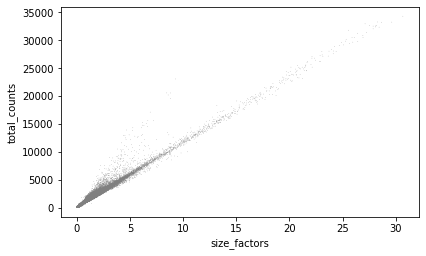

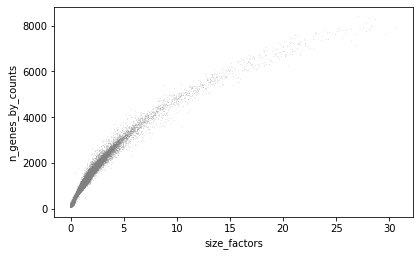

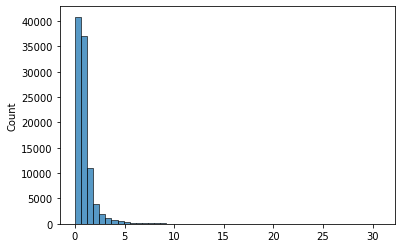

In [26]:
# Visualize the estimated size factors
adata.obs['size_factors'] = np.expand_dims(size_factors, axis=1)

sc.pl.scatter(adata, 'size_factors', 'total_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes_by_counts')

sns.histplot(size_factors, bins=50, kde=False)
plt.show()

In [27]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

In [28]:
#Normalize adata 
adata.layers["scran_normalized"] = adata.X / adata.obs['size_factors'].values[:,None]
adata.layers["scran_normalized_log1p"] = sc.pp.log1p(adata.layers["scran_normalized"])

### *sctransform* normalization

The second normalization method introduced in this chapter is sctransform. Sctransform was motivated by the observation that cell-to-cell variation in scRNA-seq data might be counfounded by biological heterogeneity with technical effects. The method utilizes Pearson residuals from regularized negative binomial regression and adds the count depth as a covariate in a generalied linear model. {cite}`germain_pipecomp_2020` showed in an independent comparision of different normaliazation techniques that this method removed the impact of sampling effects while preserving cell heteogeneity in the dataset. Sctransform does not require downsteam heuristic steps like pseudocount addition or log-transformation.

In [29]:
from scipy.sparse import issparse

In [30]:
%%R
library(sctransform)

In [ ]:
if issparse(adata.X):
    if not adata.X.has_sorted_indices:
        adata.X.sort_indices()
ro.globalenv['adata'] = adata

In [ ]:
%%R
seurat_obj = as.Seurat(adata, counts="X", data = NULL)
seurat_obj = RenameAssays(seurat_obj, originalexp = "RNA")
res <- SCTransform(object=seurat_obj, method = "glmGamPoi", return.only.var.genes = FALSE, do.correct.umi = FALSE)

In [ ]:
norm_x = ro.r('res@assays$SCT@scale.data').T
adata.layers['SCT_normalized_residuals'] = norm_x

## Feature Selection

## Dimensionality Reduction

## References

```{bibliography}
:filter: docname in docnames
```

In [30]:
import session_info
session_info.show()